# Explore data

## Load libraries

In [26]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import sys
import cv2
import random

# autoreload changes from local files
%load_ext autoreload
%autoreload 2

# dataframe display settings
pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_rows(100)
pl.Config.set_tbl_cols(50)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


polars.config.Config

In [2]:
from airbus_ship_detection import configs
from airbus_ship_detection import processing
from airbus_ship_detection import visuals

## Load and process data

In [ ]:
# load with polars
df_segments = pl.read_csv(configs.DIR_DATA / "train_ship_segmentations_v2.csv")

# add number of ships
df_segments = processing.process_labels(df_segments)

# distinguish images with and without ships
df_segments_ships = df_segments.filter(pl.col('EncodedPixels').is_not_null())
df_segments_empty = df_segments.filter(pl.col('EncodedPixels').is_null())

df_segments.head()

ImageId,EncodedPixels,n_ships,has_ship
str,str,u32,bool
"""00003e153.jpg""",null,0,false
"""0001124c7.jpg""",null,0,false
"""000155de5.jpg""","""264661 17 265429 33 266197 33 266965 33 267733 33 268501 33 269269 33 270037 33 270805 33 271573 33 …",1,true
"""000194a2d.jpg""","""360486 1 361252 4 362019 5 362785 8 363552 10 364321 10 365090 9 365858 10 366627 10 367396 9 368165…",5,true
"""000194a2d.jpg""","""51834 9 52602 9 53370 9 54138 9 54906 9 55674 7 56442 7 57210 7 57978 7 58746 7 59514 7 60282 7 6105…",5,true


## Explore data

Text(0.5, 0.98, 'Distribution of ships in images')

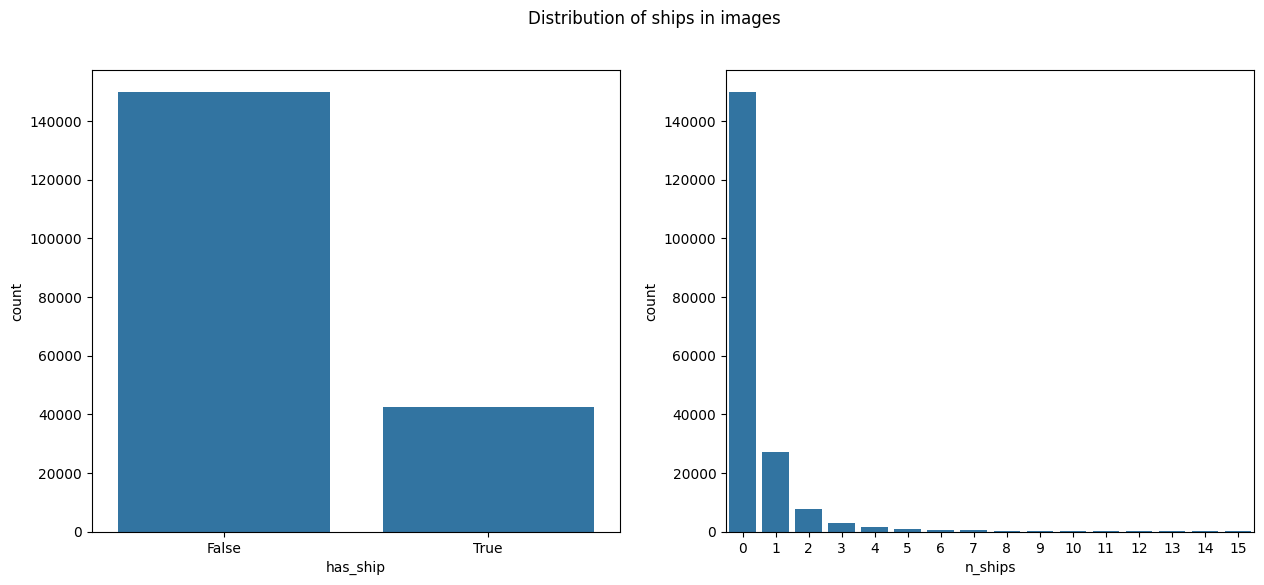

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
df_segments_unique = df_segments.unique(subset=['ImageId'])
sns.countplot(data=df_segments_unique, x='has_ship', ax=ax[0])
sns.countplot(data=df_segments_unique, x='n_ships', ax=ax[1])
fig.suptitle('Distribution of ships in images')


From this we can see a class imbalance in the dataset. Most images do not contain ships. For images that do contain ships, most contain only one ship, but there are some images with up to 15 ships.

In [72]:
rows = 5
cols = 5

# Set the random seed right before sampling for reproducibility
# This ensures consistent results regardless of previous random operations
random.seed(42)
unique_image_ids = df_segments['ImageId'].unique().to_list()
unique_image_ids.sort()
sample_image_ids = random.sample(unique_image_ids, k=(rows * cols))
print(f"Sampled {len(sample_image_ids)} unique image IDs:")
print(sample_image_ids)

Sampled 25 unique image IDs:
['deecb42e6.jpg', '26baaa8df.jpg', '08b5754b9.jpg', '5fe206a28.jpg', '557bf583e.jpg', '4dfebeccb.jpg', '30ae16312.jpg', '23be6c54b.jpg', 'ebe656273.jpg', 'be13a4681.jpg', '1e4276965.jpg', 'cdcea0e9f.jpg', '930df6e9c.jpg', '0b0d62fc4.jpg', '0a6bf9a2f.jpg', '20ba82685.jpg', '4c6a0f866.jpg', '514e82bfe.jpg', 'b01c9f2f4.jpg', 'd20ad7155.jpg', '093962312.jpg', 'c3a2973af.jpg', '456e76d67.jpg', 'f9aa3891f.jpg', 'e28cd0f26.jpg']


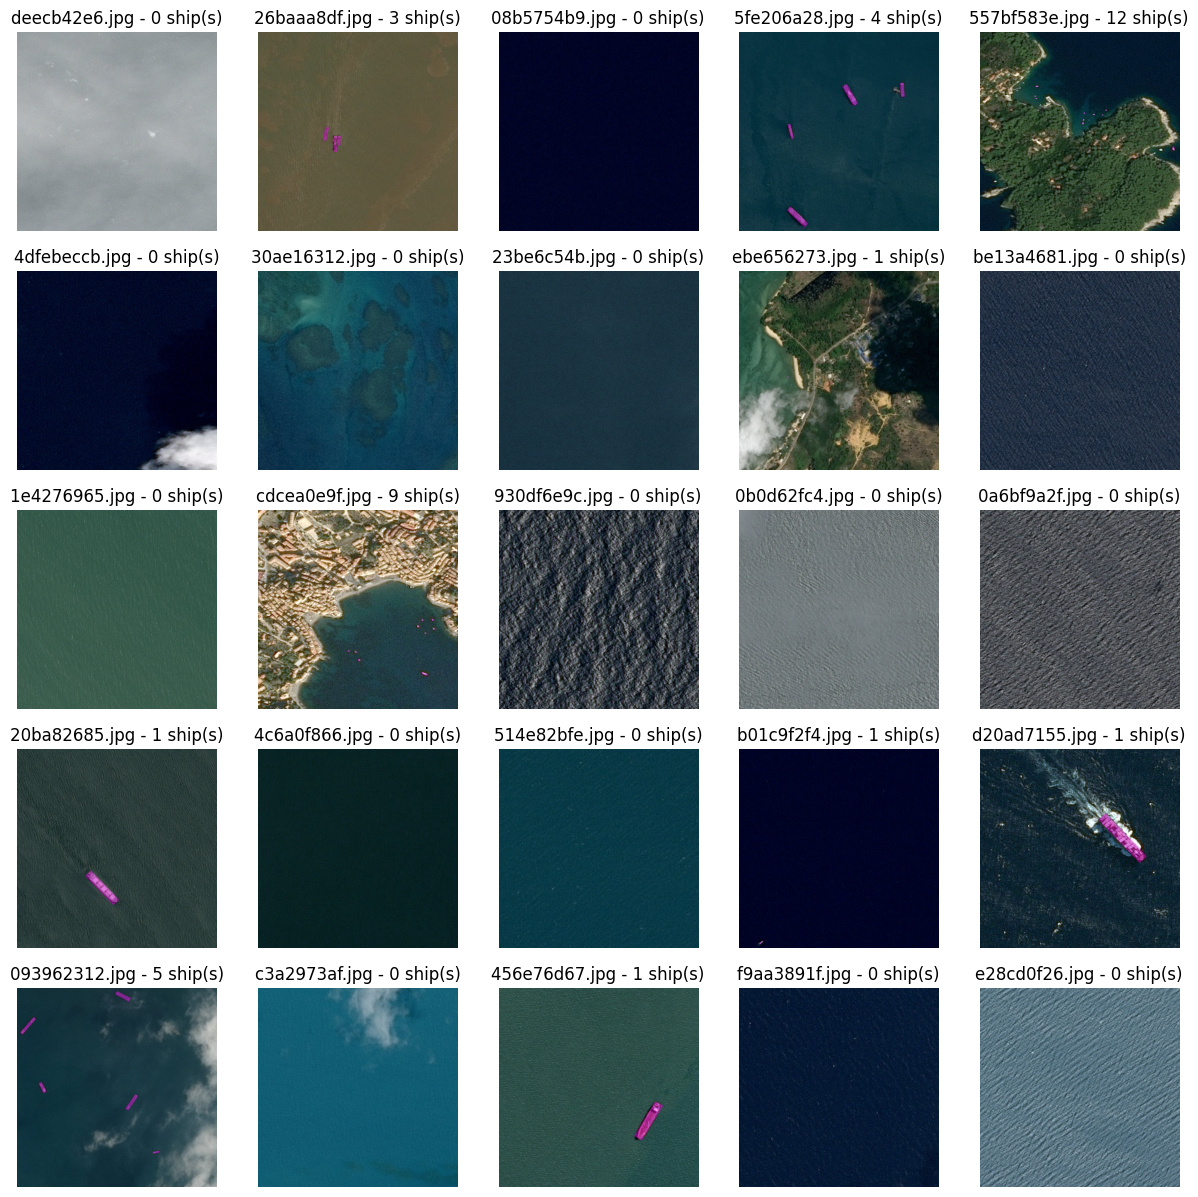

In [91]:
fig, axs = plt.subplots(rows, cols, figsize=(15, 15))

for i in range(rows):
    for j in range(cols):
        img_idx = i * cols + j
        img_name = sample_image_ids[img_idx]

        img_path = os.path.join(configs.DIR_DATA_TRAIN_IMG, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i, j].imshow(img)

        # overlay all masks for this image if they exist
        df_segments_img = df_segments.filter(pl.col("ImageId") == img_name)
        masks_img = df_segments_img.select("EncodedPixels").to_series().to_list()
        for idx in masks_img:
            if idx is not None:
                masks = processing.rle_decode(idx)
                # Overlay only positive values in masks (mask==1), keep 0s fully transparent, use yellow color
                axs[i, j].imshow(np.ma.masked_where(masks == 0, masks), alpha=0.4, cmap='spring')

        n_ships = df_segments_img['n_ships'][0]
        axs[i, j].axis('off')

        axs[i, j].set_title(f"{img_name} - {n_ships} ship(s)")